# DF: What are these texts about?

In many situations, we want our computers to summarize a big set of texts. Perhaps we don't want to go into detail, but we wish to know what people are talking about. This is a great source of information, because it allows something called *opinion mining*: are people talking positively about an artist? About a company? About the government?

Also, if you are collecting feedback, you might want to find out what are the main points your customers are complaining about.

We will get started by downloading a dataset with news from Kaggle:

In [1]:
import kagglehub
import os
import pandas as pd
from pathlib import Path

path = Path(kagglehub.dataset_download("gpreda/bbc-news"))
print("Path to dataset files:", path)
print("Files in the dataset:", os.listdir(path))
df = pd.read_csv(path / os.listdir(path)[0])
print(f"Number of news: {len(df)}")
df.head()

Path to dataset files: C:\Users\emend\.cache\kagglehub\datasets\gpreda\bbc-news\versions\1007
Files in the dataset: ['bbc_news.csv']
Number of news: 42115


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


Ok, so we have over 40000 news downloaded from BBC here.

We are going to work with the question: what was being said about the war in Ukraine?

## Exercise 1: data preparation

First of all, we will need to find all news articles that talk about Brazil.

We will need a regular expression that matches all of Brazil, Brazilian, and so on, and then we can use Pandas' built in methods to filter out the news:

In [2]:
import re
regular_expression = r'Brazil\w*' # Change for something that matches references to ukraine
df_filt = df[df['description'].str.contains(regular_expression, case=False)]
print(len(df_filt))
df_filt.head()

138


,title,pubDate,guid,link,description
744,Evangelicalism & Brazil: The religious movemen...,"Tue, 22 Mar 2022 00:01:04 GMT",https://www.bbc.co.uk/sport/football/60483820,https://www.bbc.co.uk/sport/football/60483820?...,Evangelicalism within Brazil's national footba...
1392,Brazil at work: Black and held back,"Tue, 05 Apr 2022 23:52:18 GMT",https://www.bbc.co.uk/news/world-latin-america...,https://www.bbc.co.uk/news/world-latin-america...,Brazil has one of the world's largest black po...
1430,Brazil at work: Black and held back,"Tue, 05 Apr 2022 23:52:18 GMT",https://www.bbc.co.uk/news/world-latin-america...,https://www.bbc.co.uk/news/world-latin-america...,Brazil has one of the largest black and mixed ...
2069,Rio carnival: Brazil holds first Rio de Janeir...,"Sun, 24 Apr 2022 01:49:24 GMT",https://www.bbc.co.uk/news/world-latin-america...,https://www.bbc.co.uk/news/world-latin-america...,Parades fill the streets of Brazil's Rio de Ja...
2154,Brazil Carnival: 'Bolsonaro' dancer turned int...,"Mon, 25 Apr 2022 12:12:53 GMT",https://www.bbc.co.uk/news/world-latin-america...,https://www.bbc.co.uk/news/world-latin-america...,Brazil's famous Carnival returned this year fo...


## Exercise 2: Document Frequency

First, we will identify all words that exist in our texts. One way to do such thing is to concatenate all headlines and descriptions in a single text file, then separate all words using RegEx, and then use the `set()` function to identify each word:

In [3]:
all_descriptions = ' '.join(list(df_filt['description']))
all_headlines = ' '.join(list(df_filt['title']))
all_texts = all_descriptions + ' ' + all_headlines
all_words = re.findall(r'\b\w+\b', all_texts)
all_unique_words = set(all_words)
print(len(all_unique_words))

1283


The underlying theory of opinion mining is that words that convey opinion (or: that convey the "common sense" of a dataset) appear in more documents. The number of documents in which a word appears is called *document frequency*.

We could build a dictionary in which keys are the words in our vocabulary and the values are the number of documents that word appears in. Remember, this is not the same as counting how many times that word was used: if the words appears in two documents, its frequency should be 2; however, if it appears twice in a single document, then its frequency should be 1.

After that, we can divide the counts by the number of documents so your dictionary contains the probability that a randomly selected document contains each word (or: $P(w_n | d)$).

We could study fast algorithms to calculate document frequency, but, instead, we are going to use the ready-made `CountVectorizer` class from `sklearn`.

CountVectorizer creates a $X \in \mathbb{R}^{N \times V}$ matrix where $N$ is the number of documents in the collection and $V$ is the vocabulary size. The element $x_{n,v}$ is $1$ if word $v$ appears in document $n$, and $0$ otherwise.

CountVectorizer also creates a `vocabulary_` property containing a dictionary that maps words to their indexes in the matrix.

We can use that to create a dictionary mapping words to their document frequency. 

The final dictionary should look like:

    { 
      'word1' : number_of_documents_word1_appears/total_number_of_documents,
      'word2' : number_of_documents_word2_appears/total_number_of_documents,
      ...
      'wordn' : number_of_documents_wordn_appears/total_number_of_documents,
    }

HINT: use `np.mean(x ,axis=0)` to calculate the mean value of a matrix along the rows.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, stop_words="english")
X = vectorizer.fit_transform(df_filt['description'])

# Does the word 'the' appear in document 3?
#X[3, vectorizer.vocabulary_['the']]

In [5]:
vectorizer.vocabulary_
X[30, vectorizer.vocabulary_['brazil']]

np.int64(1)

In [6]:
# Continue with your solution
doc_freq_matrix = X.mean(axis=0)
doc_freq = {
    word: doc_freq_matrix[0, vectorizer.vocabulary_[word]]
    for word in vectorizer.vocabulary_
}

## Exercise 3: stopwords

Now, see some useful manipulations. We can convert our dictionary to a Pandas dataframe and plot some values as a barplot:

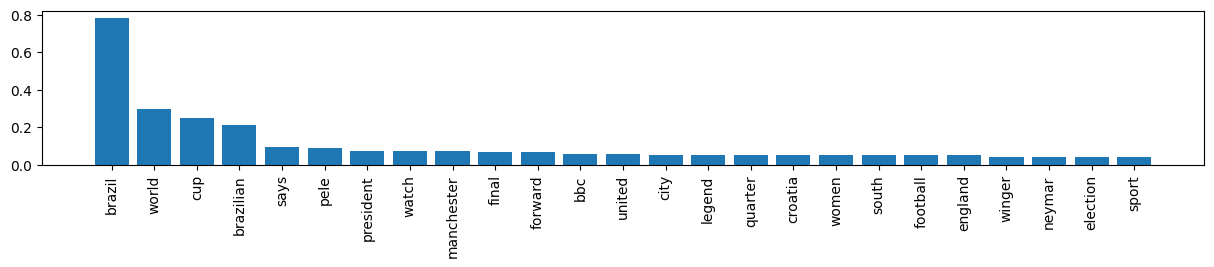

In [7]:
import matplotlib.pyplot as plt
import pandas as pd 
df_vocabulary = pd.DataFrame(doc_freq.items(), columns=['word', 'frequency'])
df_vocabulary = df_vocabulary.sort_values(by='frequency', ascending=False)
df_vocabulary.head()
plt.figure(figsize=(15,2))
plt.bar(df_vocabulary.iloc[0:25]['word'], df_vocabulary[0:25]['frequency'])
plt.xticks(rotation=90)
plt.show()

Note that there are some words that are so common that they don't tell us much about the problem, like "the" and "a". These types of words are usually avoided by using a manually-curated list of special words called "stopwords". We can inform our vectorizer to use a pre-made list of stop words by using the `stop_words` parameter:

    vectorizer = CountVectorizer(binary=True, stop_words='english')

Now, go ahead and incorporate the parameters, and run the code above again. What changes do you see in the plot?

According to this plot, what could be said about the news on Ukraine?

## Exercise 4: lemmatization

If everything went well, you should be seeing "say" and "says" with high document frequencies. However, they carry very similar information - hence they should be together.

One way to deal with that is to remember that words are composed of a stem and a suffix (like "liquid", "liquidification", "liquidize", and so on). The process of removing the suffix is called "stemming". There are some interesting processes to perform stemming.

Another approach is to use lemmatization. In lemmatization, each word is changed by its dictionary entry. It is a great process to remove plurals, for example.

There are stemmers and lemmatizers implemented in the NLTK library:

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download WordNet data
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
lemmatized_word = lemmatizer.lemmatize("cacti")

stemmed = PorterStemmer()
stemmed_word = stemmed.stem("cacti")
print(lemmatized_word, stemmed_word)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emend\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


cactus cacti


However, NLTK's implementation operates in a single word.

Make functions to apply stemming to each word in the dataset, and then run your code again. After that, try it with lemmatization. Which one is clearer?

In [9]:
def lemmattize_text(text):
    words = re.findall(r'\w+', text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


In [10]:
df_filt["lematized"] = df_filt["description"].apply(lambda x: lemmattize_text(x))

C:\Users\emend\AppData\Local\Temp\ipykernel_19844\3733323566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["lematized"] = df_filt["description"].apply(lambda x: lemmattize_text(x))


In [11]:
df_filt["lematized"]

744      Evangelicalism within Brazil s national footba...
1392     Brazil ha one of the world s largest black pop...
1430     Brazil ha one of the largest black and mixed r...
2069     Parades fill the street of Brazil s Rio de Jan...
2154     Brazil s famous Carnival returned this year fo...
                               ...                        
39506    Mother of five Alice Webb 33 died after report...
40541    Minutes after Real Madrid fan were singing for...
40907    Two Brazilian sailor prepare for a voyage that...
40944    The Brazilian wa shot when he wa wrongly suspe...
41135    The family of Alice Webb 33 gather to remember...
Name: lematized, Length: 138, dtype: object

## Exercise 5: the inverted index

You might have figured out by now that searching for words in a large collection is very inneficient. To avoid such searches, many databases implement a data structure called an "inverted index".

The inverted index is essentially a dictionary whose key is a word from the vocabulary, and whose value is a list (or set) of references to documents that contain that word.

As an example, the inverted index below:

    {
        'brazil' : [0, 1, 2],
        'argentina' : [2, 3]
    }

means that "brazil" appears in documents 0, 1, and 2, while "argentina" appears in documents 2 and 3.

You might want to stem/lemmatize the words before implementing the inverted index.

(a) Complete the function below to generate an inverted index for a news dataframe, which will allow searching among news based on keywords. HINT: use `CountVectorizer` to save yourself some time!

(b) Use your inverted index to search for news documents that contain "brazil" AND "president". What does the DF distribution say in this case?

(c) Use your inverted index to search for news documents that contain "brazil" BUT DO NOT CONTAIN "football" or "soccer". How is the DF distribution in this case?

In [12]:
from typing import Dict

def make_inverted_index_from_df(df : pd.DataFrame) -> Dict:
    return {}

## Exercise 6: Topic modelling

Remember that our documents are now represented in a $X \in \mathbb{R}^{D \times V}$ matrix. In this matrix, each word is completely independent from each other. However, we know that some words are more likely to appear together in real texts.

These groups of words that appear together are called "topics". The act of finding topics is called "topic modelling". One of the current state-of-the-art ideas for topic modelling is called [Latent Dirichlet Allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), or LDA.

LDA is a fast technique that assumes $X$ contains discrete counts of words in each document, and then calculates an approximation:

$$
X \approx B A,
$$

where $B \in \mathbb{R}^{D \times T}$ and $A \in \mathbb{R}^{T \times V}$, and $T$ is an arbitrarily chosen number of topics. Essentially, $B$ informs how much each document participates in each topic, and $A$ informs how much each word in the vocabulary participates in each topic.

The code to use LDA adequately is a bit tricky.

Here is one example. Interpret the outputs, and then try to change the number of topics.

Which matrix ($B$ or $A$) is represented by `lda_model.components_`?

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        stop_words='english',
        max_df=0.7,
        min_df=2,
    )),
    ('lda',
     LatentDirichletAllocation(
         n_components=10,
         max_iter=300,
         random_state=42,
     )),
])

pipeline.fit(df_filt['description'])

lda_output = pipeline.transform(df_filt['description'])
lda_model = pipeline.named_steps['lda']
feature_names = pipeline.named_steps['vectorizer'].get_feature_names_out()

# Print the most prominent words in each topic
# Print the number of documents whose most prominent topic is this one
most_prominent_topic = lda_output.argmax(axis=1)
for topic_idx, topic in enumerate(lda_model.components_):
    num_documents = (most_prominent_topic == topic_idx).sum()
    print(f"Topic {topic_idx} ({num_documents} documents):")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 0 (12 documents):
president black world brazilian country football people record largest posts
Topic 1 (12 documents):
world cup south late beat korea years finals won dominant
Topic 2 (15 documents):
manchester united antony winger deal sign city brazilian allegations sport
Topic 3 (12 documents):
cup world quarter croatia watch final victory england neymar forward
Topic 4 (15 documents):
brazilian lift butt year undergoing died webb 33 alice club
Topic 5 (15 documents):
world cup says women final football team games role tears
Topic 6 (16 documents):
election presidential crisis people cost living new amazon state issue
Topic 7 (11 documents):
brazilian surfer gabriel medina paris globe image striking imaginations captured
Topic 8 (19 documents):
pele brazilian forward watch cup world group indigenous match goals
Topic 9 (11 documents):
world cup phil mcnulty largest bbc england richarlison wembley defeat


## Exercise 7: a solution with LLMs

So far, we have learned how to use classic NLP techniques to get a gist of the news. However, large language models (LLMs) seem to be the new state of the art for such. 

Well, we would like a summary of all news related to Brazil. Our classical methods are highly biased by the fact that most news are about football - let's see what LLMs can do for us here!

For such, we will use Google Gemni, which has a great free tier that is just enough for our learning purposes. Go to https://aistudio.google.com/ and get yourself an API key. Then, add the key to the `.env` file in your system.

Check how prompting works - it is essentially like using ChatGPT.

1. Can you control the prompts so that summaries are more verbose or less verbose?
1. What happens if you don't provide the model with the news you want a summary of - maybe changing the prompt to "give me a summary of news in Brazil from 2022 to 2024"?
1. What happens if you ask a direct question?
1. How does these summaries compare with the topics generated by LDA?

In [14]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
#GEMINI_API_KEY = # Go to https://aistudio.google.com/ to get a key. DO NOT commit your key to the repository!

# Start the use of the API
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

# Make our prompt here
news = '\n\nAnother news '.join(list(df_filt['description']))
prompt = f"I have these pieces of news: {news}. Can you summarize them for me?"

# Use our prompt
response = model.generate_content(prompt)

# Print our response
print(response.text)

These news stories cover a wide range of topics related to Brazil, from politics and elections to sports, culture, and social issues.  Here's a summary categorized for clarity:

**Politics & Social Issues:**

* **Elections:**  The Brazilian presidential election was a major focus, with coverage of campaigning, the results (Lula's victory over Bolsonaro), anxieties surrounding the vote, and the subsequent storming of Congress by Bolsonaro supporters.  The election's impact on the Amazon rainforest and poverty were also highlighted.  Evangelical Christians, particularly women of color, played a significant kingmaker role.
* **Social Inequality:** Brazil's stark racial inequality is addressed, with black Brazilians significantly underrepresented in managerial positions.
* **Cost of Living Crisis:**  The severe cost of living crisis is impacting many Brazilians, leading to extreme measures for survival and contributing to the political climate.
* **Amazon:** The Amazon rainforest's future 

## Exercise 8: combining everything

In general, the more we provide LLMs with specific information in the prompt, the better is its output (also, using less data can decrease our cloud costs...). Based on the code above, make a proof-of-concept code (probably within this notebook?) that first uses LDA to roughly identify topics, and then uses the LLM to make a summary of documents within a topic chosen by the user.


In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        stop_words='english',
        max_df=0.7,
        min_df=2,
    )),
    ('lda',
     LatentDirichletAllocation(
         n_components=10,
         max_iter=300,
         random_state=42,
     )),
])

pipeline.fit(df_filt['description'])

lda_output = pipeline.transform(df_filt['description'])
lda_model = pipeline.named_steps['lda']
feature_names = pipeline.named_steps['vectorizer'].get_feature_names_out()

In [ ]:
news = '\n\nAnother news '.join(list(df_filt['description']))
prompt = f"I have these pieces of news: {news}. Can you summarize them for me?"

# Use our prompt
response = model.generate_content(prompt)